<h1>VRI Productivity Analysis - DuckDB</h1>

This notebook uses DuckDB and the VRI Parquet file on NRS objectstore to download the VRI, clip to an AOI and preform analysis of site index values. It was created for WMB Planning in the Northeast Region as part of the Blueberry River First Nation Implementation Agreement. Written by North Ross in October 2024.

DuckDB is used due to its very fast processing time with large datasets such as the VRI, especially when preforming clips, intersects and spatial joins. The initial idea for this analysis was to combine with the PSPL data. This did not end up being used in the final product, but the PSPL_testing.ipynb noteboook preserves my experimenting with it. DuckDB was very useful for this operation.

<a href="https://jupysql.ploomber.io/en/latest/api/magic-plot.html">JupySQL</a> is used to execute the DuckDB SQL and create plots, except in some cases where the duckdb conn.sql() function is used to implement directly in Python (in a loop for example)

Further experiments could use <a href="https://developmentseed.org/lonboard/latest/">lonboard</a> with the .from_duckdb() method to try quickly visually inspecting the data.

Otherwise, you can export the data to another format or use the <a href="https://plugins.qgis.org/plugins/qduckdb/">QGIS DuckDB extension</a> to plot the data (this works well in this case and is quite fast)

In [ ]:
# install some libraries (if not already installed)
%pip install --upgrade duckdb
%pip install jupysql
%pip install duckdb-engine
%pip install matplotlib

In [1]:
# load libraries/jupyter extensions
import geopandas as gpd
import duckdb
from shapely.geometry import shape
import fiona
import os
%load_ext sql

In [14]:
# sql ggplot
from sql.ggplot import ggplot, aes, geom_boxplot, geom_histogram, facet_wrap

In [2]:
# Set local variables, paths to AOI, vri, other data.
# Note the aflb data is not yet incorporated into the script.

# conn = duckdb.connect(database=':memory:')
workingdir = r'C:\Users\nross\OneDrive - Government of BC\Documents\BRFNDocs\work-test'
db = os.path.join(workingdir,'vri_analysis.db')
vri_url = "https://nrs.objectstore.gov.bc.ca/rczimv/geotest/veg_comp_layer_r1_poly.parquet"
aoi_path = r'\\spatialfiles2.bcgov\work\FOR\RNI\DPC\General_User_Data\nross\BRFN_NE_LUPCE_Analysis\WMB_Study_Area_2024_07_30\WMB_Study_Area_2024_07_30.shp'
aflb_gdb = r'\\spatialfiles2.bcgov\work\FOR\RNI\DPC\General_User_Data\nross\BRFN_NE_LUPCE_Analysis\BRFNLupce.gdb'


conn = duckdb.connect(database=db)
conn.install_extension("httpfs")
conn.install_extension("spatial")
conn.load_extension("httpfs")
conn.load_extension("spatial")


In [6]:
# Setup sql magic and show current tables
%sql conn --alias duckdb
%sql select * from information_schema.tables

Running query in 'duckdb'

table_catalog,table_schema,table_name,table_type,self_referencing_column_name,reference_generation,user_defined_type_catalog,user_defined_type_schema,user_defined_type_name,is_insertable_into,is_typed,commit_action,TABLE_COMMENT
vri_analysis,main,pspl,BASE TABLE,None,None,None,None,None,YES,NO,None,None
vri_analysis,main,species,BASE TABLE,None,None,None,None,None,YES,NO,None,None
vri_analysis,main,vri,BASE TABLE,None,None,None,None,None,YES,NO,None,None
vri_analysis,main,vri_pspl_species,BASE TABLE,None,None,None,None,None,YES,NO,None,None


In [31]:
# read AOI as shapely geom
with fiona.open(aoi_path) as shapefile:
    aoi = shape(shapefile[0]['geometry'])
    aoi_area_ha = aoi.area/10000
    print(round(aoi_area_ha, 2))


2179741.04


<h1>Download VRI</h1>

The next section downloads the relevant 2023 VRI R1 data by querying a parquet object in the nrs object storage, then clips it to our AOI.

In [103]:
%%sql
# create vri table
DROP TABLE IF EXISTS vri;

CREATE TABLE vri as (
    select Shape as geom, OBJECTID, BCLCS_LEVEL_2, BEC_ZONE_CODE,
      SPECIES_CD_1, SPECIES_PCT_1, SPECIES_CD_2, SPECIES_PCT_2, SPECIES_CD_3, SPECIES_PCT_3,
      SPECIES_CD_4, SPECIES_PCT_4, SPECIES_CD_5, SPECIES_PCT_5, SPECIES_CD_6, SPECIES_PCT_6,
      PROJ_AGE_CLASS_CD_1, SITE_INDEX, POLYGON_AREA
    from '{{vri_url}}' -- read parquet file from objectstorage
    where ST_Intersects (geom, ST_GeomFromText('{{aoi}}'))
);

Running query in 'duckdb'

Count
188049


In [104]:
%%sql
# Clip VRI to AOI
UPDATE vri
SET geom = (
    SELECT
        CASE WHEN ST_Intersects(geom, ST_Boundary(ST_GeomFromText('{{aoi}}')))
                THEN ST_Intersection(geom, ST_GeomFromText('{{aoi}}'))
                ELSE geom END
    from vri v
    WHERE vri.OBJECTID = v.OBJECTID
    );

UPDATE vri
set POLYGON_AREA = ST_Area(geom)/10000;

Running query in 'duckdb'

Count
188049


In [105]:
# check if VRI area roughly matches AOI input. 
%sql select FORMAT('{:t,.2f}', sum(polygon_area)) AS VRIAreaHa, FORMAT('{:t,.2f}', {{aoi_area_ha}}) as AOIAreaHa from vri

Running query in 'duckdb'

VRIAreaHa,AOIAreaHa
"2,179,740.98","2,179,741.04"


<h2>Deciduous Percent</h2>

Calculate Deciduous Percent and Stand Type. We use 25% cutoff.

The <a>VRI Data Dictionary</a> lists tree species codes under the entry for SPECIES_CD_1. All "hardwood species" codes were put into deciduousList, although most do not occur in our study area (especially as leading species). We only use the first letter to catch entries which only look at first letter (e.g. undifferentiated poplar = 'A')



In [110]:
# Create deciduous % column
deciduousList = ['A', 'D', 'E', 'G', 'K', 'M', 'Q', 'R', 'U', 'V', 'W']
deciduousListStr = ("(\'" + "\', \'".join(deciduousList) + "\')")

# create column if not exist
result = conn.execute(f"""
  SELECT COUNT(*) AS column_exists
  FROM information_schema.columns
  WHERE table_name = 'vri' AND column_name = 'DECID_PCT';
""").fetchone()
if result[0] == 0:
  conn.execute(f"ALTER TABLE vri ADD COLUMN DECID_PCT DOUBLE;")
  
# create column if not exist
result = conn.execute(f"""
  SELECT COUNT(*) AS column_exists
  FROM information_schema.columns
  WHERE table_name = 'vri' AND column_name = 'STAND_TYPE_25';
""").fetchone()
if result[0] == 0:
  conn.execute(f"ALTER TABLE vri ADD COLUMN STAND_TYPE_25 VARCHAR;")

In [111]:
%%sql

# For each of the six species codes, if the first letter is in our list of deciduous species, add it to our DECID_PCT column. Else add zero.
UPDATE vri
SET DECID_PCT = (
  CASE WHEN SPECIES_CD_1[:1] IN {{deciduousListStr}} THEN SPECIES_PCT_1 ELSE 0 END +
  CASE WHEN SPECIES_CD_2[:1] IN {{deciduousListStr}} THEN SPECIES_PCT_2 ELSE 0 END +
  CASE WHEN SPECIES_CD_3[:1] IN {{deciduousListStr}} THEN SPECIES_PCT_3 ELSE 0 END +
  CASE WHEN SPECIES_CD_4[:1] IN {{deciduousListStr}} THEN SPECIES_PCT_4 ELSE 0 END +
  CASE WHEN SPECIES_CD_5[:1] IN {{deciduousListStr}} THEN SPECIES_PCT_5 ELSE 0 END +
  CASE WHEN SPECIES_CD_6[:1] IN {{deciduousListStr}} THEN SPECIES_PCT_6 ELSE 0 END
);

# If no leading species is listed (SPECIES_CD_1 = NULL), set DECID_PCT to NULL.
UPDATE vri
SET DECID_PCT = (
  CASE WHEN SPECIES_CD_1 IS NULL THEN NULL ELSE DECID_PCT END
);

# Use 25% cutoffs to assign a stand type. If DECID_PCT is NULL then set this to NULL.
UPDATE vri
SET STAND_TYPE_25 = (
  CASE WHEN DECID_PCT <= 25 THEN 'Coniferous' ELSE 
    CASE WHEN DECID_PCT >= 75 THEN 'Deciduous' ELSE 
      CASE WHEN DECID_PCT IS NOT NULL THEN 'Mixed' ELSE NULL END
    END
  END
);

Running query in 'duckdb'

Count
188049


In [72]:
# Weirdly there are some polygons that have a site index but no listed leading species...
%sql select count(SITE_INDEX), sum(POLYGON_AREA), avg(SITE_INDEX) from vri where SPECIES_CD_1 is null and SITE_INDEX is not null

Running query in 'duckdb'

count(SITE_INDEX),sum(POLYGON_AREA),avg(SITE_INDEX)
230,3017.180842383417,15.560869565217391


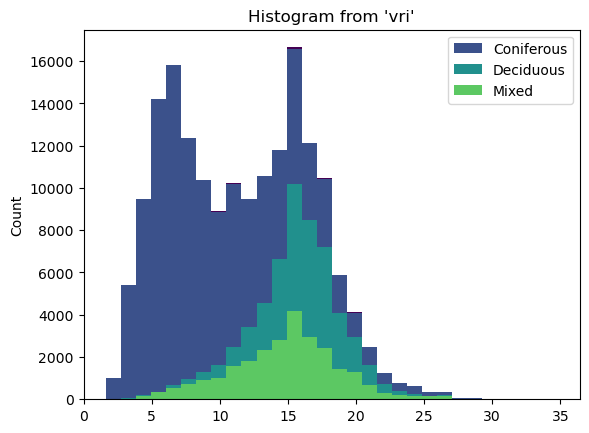

In [98]:
# Take a look at the output
# Note that sql.ggplot() doesn't support the 'weights' argument so we can't weight the polygons by area. So this is just looking at the number of polygons with x site index. 
# We could group these into bins and then do a bar chart but this would take time to both code and process. So it's faster to just do it in R.
# This is slightly different from the actual area. See the R script for proper charts.
(ggplot("vri", aes(x="SITE_INDEX")) + geom_histogram(bins=30, fill="STAND_TYPE_25", cmap='viridis_r'))

<h2>Productivity Bins</h2>

The above data was loaded into R to inspect the distribution of site index within each stand type by leading species. See 'SiteIndexAnalysis.R' and the discussion paper.

It was determined to use the following categories for our productivity bins:

<b>Coniferous</b>: <= 10 is Low, >= 18 is High

<b>Deciduous</b>: <= 12 is Low, >= 20 is High

<b>Mixed</b>: <= 10 is low, >= 20 is High

In [8]:
%%sql
ALTER TABLE vri
ADD COLUMN prod_bin VARCHAR;

Running query in 'duckdb'

Success


In [9]:
%%sql
# Sort into productivity bins

UPDATE vri
SET prod_bin = 
IF (
    STAND_TYPE_25 = 'Coniferous',
    IF (
        SITE_INDEX <= 10,
        'Low',
        IF (
            SITE_INDEX >= 18,
            'High',
            IF (SITE_INDEX IS NOT NULL, 'Medium', NULL)
            )
        ),
    IF (STAND_TYPE_25 = 'Deciduous',
        IF (
            SITE_INDEX <= 12,
            'Low',
            IF (
                SITE_INDEX >= 20,
                'High',
                IF (SITE_INDEX IS NOT NULL, 'Medium', NULL)
                )
            ),
        IF (STAND_TYPE_25 = 'Mixed',
            IF (
                SITE_INDEX <= 10,
                'Low',
                IF (
                    SITE_INDEX >= 20,
                    'High',
                    IF (SITE_INDEX IS NOT NULL, 'Medium', NULL)
                    )
                ),
            NULL
        )
    )
)


Running query in 'duckdb'

Count
188049


In [11]:
%config SqlMagic.displaylimit = 30

In [12]:
%%sql 
# Examine distribution of outputs.
SELECT 
    STAND_TYPE_25 as "Stand Composition", 
    prod_bin as "Productivity Class", 
    ROUND(AVG(SITE_INDEX), 1) as "Mean Site Index", 
    FORMAT('{:t,.0f}', SUM(POLYGON_AREA)) AS "Total Area (ha)",
    ROUND(SUM(POLYGON_AREA) * 100.0 / SUM(SUM(POLYGON_AREA)) OVER (PARTITION BY STAND_TYPE_25), 1) AS "% of Stand Type Area",
    ROUND(SUM(POLYGON_AREA) * 100.0 / SUM(SUM(POLYGON_AREA)) OVER (), 1) AS "% of Study Area"
    

from vri 
    GROUP BY STAND_TYPE_25, prod_bin
    ORDER BY STAND_TYPE_25, "Mean Site Index", "Total Area (ha)"

Running query in 'duckdb'

Stand Composition,Productivity Class,Mean Site Index,Total Area (ha),% of Stand Type Area,% of Study Area
Coniferous,Low,6.5,"880,961",64.2,40.4
Coniferous,Medium,13.5,"406,480",29.6,18.6
Coniferous,High,20.4,"80,715",5.9,3.7
Coniferous,None,None,"3,648",0.3,0.2
Deciduous,Low,10.2,"33,720",8.6,1.5
Deciduous,Medium,16.2,"327,416",83.7,15.0
Deciduous,High,21.6,"29,997",7.7,1.4
Deciduous,None,None,106,0.0,0.0
Mixed,Low,7.8,"36,563",12.8,1.7
Mixed,Medium,15.1,"223,044",78.0,10.2


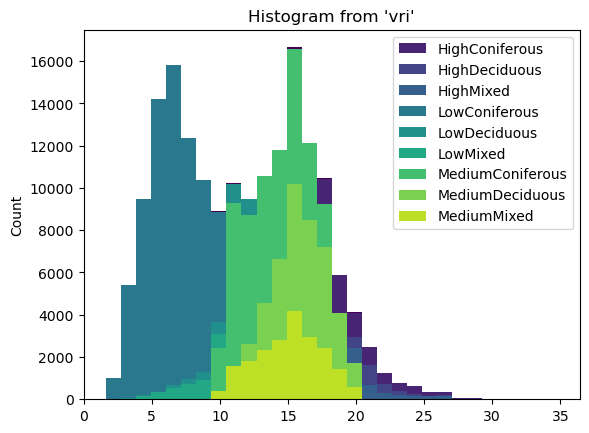

In [15]:
(ggplot("vri", aes(x="SITE_INDEX")) + geom_histogram(bins=30, fill="CONCAT(prod_bin, STAND_TYPE_25)", cmap='viridis_r'))
# same disclaimer as above - this shows polygon count not area.

In [16]:
conn.close()